<a href="https://colab.research.google.com/github/Andre6o6/mlcourse-2019/blob/master/task3_AIO_with_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Homework: https://drive.google.com/file/d/0B8Duph3WCZx2Q0FNSm5DczF2T0Rzck05TTUtYW84LUxfZTg4/view

Helpfull info:

* http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf
* http://cs231n.github.io/neural-networks-case-study/

In [0]:
import numpy as np

In [0]:
class Module(object):
    """
    Forward:
        
                    input -> [module] -> output

    Backward:

        grad(w.r.t.)Input <- [module] <- grad(w.r.t.)Output
                                      ^- input

    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True
    
    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.
        
        This includes 
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput
    

    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field. 
        """
        
        # The easiest case:
            
        # self.output = input 
        # return self.output
        
        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input. 
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.
        
        The shape of `gradInput` is always the same as the shape of `input`.
        """
        
        # The easiest case:
        
        # self.gradInput = gradOutput 
        # return self.gradInput
        
        pass   
    
    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass
    
    def zeroGradParameters(self): 
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass
        
    def getParameters(self):
        """
        Returns a list with its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
        
    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
    
    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True
    
    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False
    
    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Module"

In [0]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially. 
         
         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`. 
    """
    
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:
        
            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})   
        """
        x = input
        for i in range(len(self.modules)):
            x = self.modules[i].forward(x)
        self.output = x
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:
            
            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)   
            gradInput = module[0].backward(input, g_1)        
        """
        g = gradOutput
        for i in reversed(range(len(self.modules))):
            y_prev = input if i==0 else self.modules[i-1].output
            g = self.modules[i].backward(y_prev, g)
        self.gradInput = g
        return self.gradInput
      

    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)
    
    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()
    
    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

See: http://cs231n.stanford.edu/handouts/linear-backprop.pdf

In [0]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # Xavier initialization (but with uniform distribution(?))
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_in, n_out))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):        
        self.output = np.matmul(input, self.W) + self.b
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.matmul(gradOutput, self.W.T)
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradW = np.matmul(input.T, gradOutput)
        self.gradb = np.sum(gradOutput, axis=0)
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[0],s[1])
        return q

See: https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/

In [0]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input):
        # start with normalization for numerical stability
        shiftx = np.subtract(input, input.max(axis=1, keepdims=True))
        exps = np.exp(shiftx)
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        b,n = gradOutput.shape
        self.gradInput = np.zeros_like(self.output)
        for i in range(b):
            jacobian = self.output[i].reshape(-1,1) * (np.eye(n) - self.output[i])
            self.gradInput[i] = np.matmul(gradOutput[i], jacobian)
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

See: https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

In [0]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha=0.1):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = 0 
        self.moving_variance = 0
        
    def updateOutput(self, input):
        if (self.training):
            batch_mean = np.mean(input, axis=0)
            batch_variance = np.var(input, axis=0)

            self.moving_mean = self.moving_mean * self.alpha + batch_mean * (1 - self.alpha)
            self.moving_variance = self.moving_variance * self.alpha + batch_variance * (1 - self.alpha)

            self.output = (input - batch_mean) / np.sqrt(batch_variance + self.EPS)
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        mu = np.mean(input, axis=0)
        var = np.var(input, axis=0)
        
        B = input.shape[0]        #TODO check dims
        self.gradInput = 1 / np.sqrt(var + self.EPS) * (gradOutput - 1/B * np.sum(gradOutput, axis=0) \
                                                        - 1/B * (input - mu) / (var + self.EPS) * np.sum(gradOutput * (input - mu), axis=0))
        return self.gradInput
    
    def __repr__(self):
        return "BatchNormalization"

In [0]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)
        
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output
        
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)
    
    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)
        
    def getParameters(self):
        return [self.gamma, self.beta]
    
    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]
    
    def __repr__(self):
        return "ChannelwiseScaling"

In [0]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        
        self.p = p
        self.mask = None
        
    def updateOutput(self, input):
        # Your code goes here. ################################################
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        return self.gradInput
        
    def __repr__(self):
        return "Dropout"

In [0]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

In [0]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function 
            associated to the criterion and return the result.
            
            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result. 

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput   

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Criterion"

In [0]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()
        
    def updateOutput(self, input, target):   
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output 
 
    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

In [0]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()
    
    def updateOutput(self, input):
        # start with normalization for numerical stability
        shiftx = np.subtract(input, input.max(axis=1, keepdims=True))
        self.output = shiftx - np.log(np.sum(np.exp(shiftx), axis=1, keepdims=True))
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        shiftx = np.subtract(input, input.max(axis=1, keepdims=True))
        exps = np.exp(shiftx)
        softmax = exps / np.sum(exps, axis=1, keepdims=True)
        self.gradInput = gradOutput - softmax * np.sum(gradOutput, axis=1, keepdims=True)
        return self.gradInput
    
    def __repr__(self):
        return "LogSoftMax"

In [0]:
class NLLCriterion(Criterion):
    def __init__(self):
        a = super(NLLCriterion, self)
        super(NLLCriterion, self).__init__()
        
    def updateOutput(self, input, target):
        B = input.shape[0]
        loss = - input[range(B), target]
        self.output = np.sum(loss) / B
        return self.output

    def updateGradInput(self, input, target):
        B = input.shape[0]
        self.gradInput = np.zeros_like(input)
        self.gradInput[range(B), target] = - 1/B
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

In [0]:
class CrossEntropyLoss(Criterion):
    """
    Combines LogSoftmax and NLLLoss in one single class.
    """
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        
    def updateOutput(self, input, target):   
        """
        Expects labels as targets, not onehot vectors
        """
        shiftx = np.subtract(input, input.max(axis=1, keepdims=True))
        loss = - shiftx[range(shiftx.shape[0]), target] + np.log(np.sum(np.exp(shiftx), axis=1))
        self.output = np.sum(loss) / input.shape[0]
        return self.output
 
    def updateGradInput(self, input, target):
        shiftx = np.subtract(input, input.max(axis=1, keepdims=True))
        exps = np.exp(shiftx)
        softmax = exps / np.sum(exps, axis=1, keepdims=True)
        softmax[range(input.shape[0]), target] -= 1

        self.gradInput = softmax / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "CrossEntropyLoss"

In [0]:
#TESTING

In [0]:
import torch
from torch.autograd import Variable
import numpy
import unittest

In [0]:
class TestLayers(unittest.TestCase):
    def test_Linear(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in, n_out = 2, 3, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.Linear(n_in, n_out)
            custom_layer = Linear(n_in, n_out)
            custom_layer.W = torch_layer.weight.data.numpy().T
            custom_layer.b = torch_layer.bias.data.numpy()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-10, 10, (batch_size, n_out)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))
        
            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

            # 3. check layer parameters grad
            custom_layer.accGradParameters(layer_input, next_layer_grad)
            weight_grad = custom_layer.gradW
            bias_grad = custom_layer.gradb
            torch_weight_grad = torch_layer.weight.grad.data.numpy().T
            torch_bias_grad = torch_layer.bias.grad.data.numpy()
            self.assertTrue(np.allclose(torch_weight_grad, weight_grad, atol=1e-6))
            self.assertTrue(np.allclose(torch_bias_grad, bias_grad, atol=1e-6))

    def test_SoftMax(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.Softmax(dim=1)
            custom_layer = SoftMax()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.random((batch_size, n_in)).astype(np.float32)
            next_layer_grad /= next_layer_grad.sum(axis=-1, keepdims=True)
            next_layer_grad = next_layer_grad.clip(1e-5,1.)
            next_layer_grad = 1. / next_layer_grad

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-5))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-5))

    def test_LogSoftMax(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.LogSoftmax(dim=1)
            custom_layer = LogSoftMax()

            layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.random((batch_size, n_in)).astype(np.float32)
            next_layer_grad /= next_layer_grad.sum(axis=-1, keepdims=True)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_BatchNormalization(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 32, 16
        for _ in range(100):
            # layers initialization
            slope = np.random.uniform(0.01, 0.05)
            alpha = 0.9
            custom_layer = BatchNormalization(alpha)
            custom_layer.train()
            torch_layer = torch.nn.BatchNorm1d(n_in, eps=custom_layer.EPS, momentum=1.-alpha, affine=False)
            custom_layer.moving_mean = torch_layer.running_mean.numpy().copy()
            custom_layer.moving_variance = torch_layer.running_var.numpy().copy()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-5))

            # 3. check moving mean
            self.assertTrue(np.allclose(custom_layer.moving_mean, torch_layer.running_mean.numpy()))
            # we don't check moving_variance because pytorch uses slightly different formula for it:
            # it computes moving average for unbiased variance (i.e var*N/(N-1))
            #self.assertTrue(np.allclose(custom_layer.moving_variance, torch_layer.running_var.numpy()))

            # 4. check evaluation mode
            custom_layer.moving_variance = torch_layer.running_var.numpy().copy()
            custom_layer.evaluate()
            custom_layer_output = custom_layer.updateOutput(layer_input)
            torch_layer.eval()
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

    def test_Sequential(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            alpha = 0.9
            torch_layer = torch.nn.BatchNorm1d(n_in, eps=BatchNormalization.EPS, momentum=1.-alpha, affine=True)
            torch_layer.bias.data = torch.from_numpy(np.random.random(n_in).astype(np.float32))
            custom_layer = Sequential()
            bn_layer = BatchNormalization(alpha)
            bn_layer.moving_mean = torch_layer.running_mean.numpy().copy()
            bn_layer.moving_variance = torch_layer.running_var.numpy().copy()
            custom_layer.add(bn_layer)
            scaling_layer = ChannelwiseScaling(n_in)
            scaling_layer.gamma = torch_layer.weight.data.numpy()
            scaling_layer.beta = torch_layer.bias.data.numpy()
            custom_layer.add(scaling_layer)
            custom_layer.train()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.backward(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-5))

            # 3. check layer parameters grad
            weight_grad, bias_grad = custom_layer.getGradParameters()[1]
            torch_weight_grad = torch_layer.weight.grad.data.numpy()
            torch_bias_grad = torch_layer.bias.grad.data.numpy()
            self.assertTrue(np.allclose(torch_weight_grad, weight_grad, atol=1e-6))
            self.assertTrue(np.allclose(torch_bias_grad, bias_grad, atol=1e-6))

    def test_NLLCriterion(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.NLLLoss()
            custom_layer = NLLCriterion()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            layer_input = torch.nn.LogSoftmax(dim=1)(Variable(torch.from_numpy(layer_input))).data.numpy()
            target_labels = np.random.choice(n_in, batch_size)
            #target = np.zeros((batch_size, n_in), np.float32)
            #target[np.arange(batch_size), target_labels] = 1  # one-hot encoding

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input, target_labels)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var, 
                                                 Variable(torch.from_numpy(target_labels), requires_grad=False))
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, target_labels)
            torch_layer_output_var.backward()
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

    def test_CrossEntropyLoss(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            torch_layer = torch.nn.CrossEntropyLoss()
            custom_layer = CrossEntropyLoss()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            layer_input = torch.nn.LogSoftmax(dim=1)(Variable(torch.from_numpy(layer_input))).data.numpy()
            target_labels = np.random.choice(n_in, batch_size)
            #target = np.zeros((batch_size, n_in), np.float32)
            #target[np.arange(batch_size), target_labels] = 1  # one-hot encoding

            # 1. check layer output
            custom_layer_output = custom_layer.updateOutput(layer_input, target_labels)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var, 
                                                 Variable(torch.from_numpy(target_labels), requires_grad=False))
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.updateGradInput(layer_input, target_labels)
            torch_layer_output_var.backward()
            torch_layer_grad_var = layer_input_var.grad
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6))

suite = unittest.TestLoader().loadTestsFromTestCase(TestLayers)
unittest.TextTestRunner(verbosity=2).run(suite)

test_BatchNormalization (__main__.TestLayers) ... ok
test_ClassNLLCriterion (__main__.TestLayers) ... ok
test_CrossEntropyLoss (__main__.TestLayers) ... ok
test_Linear (__main__.TestLayers) ... ok
test_LogSoftMax (__main__.TestLayers) ... ok
test_Sequential (__main__.TestLayers) ... ok
test_SoftMax (__main__.TestLayers) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.607s

OK


<unittest.runner.TextTestResult run=7 errors=0 failures=0>

In [0]:
#TRAINING

In [0]:
#!wget yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
#!wget yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
#!wget yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
#!wget yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

In [0]:
#!gzip -d train-images-idx3-ubyte.gz

In [15]:
!wget https://www.python-course.eu/data/mnist/mnist_train.csv
!wget https://www.python-course.eu/data/mnist/mnist_test.csv

--2019-11-26 09:41:10--  https://www.python-course.eu/data/mnist/mnist_train.csv
Resolving www.python-course.eu (www.python-course.eu)... 138.201.17.115, 2a01:4f8:171:286f::4
Connecting to www.python-course.eu (www.python-course.eu)|138.201.17.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  27.1MB/s    in 4.4s    

2019-11-26 09:41:20 (23.5 MB/s) - ‘mnist_train.csv’ saved [109575994/109575994]

--2019-11-26 09:41:21--  https://www.python-course.eu/data/mnist/mnist_test.csv
Resolving www.python-course.eu (www.python-course.eu)... 138.201.17.115, 2a01:4f8:171:286f::4
Connecting to www.python-course.eu (www.python-course.eu)|138.201.17.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [text/csv]
Saving to: ‘mnist_test.csv’

mnist_test.csv      100%[===================>]  17.44M  13.7MB/s    in 1.3s    

2

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
image_size = 28
image_pixels = image_size * image_size
data_path = ""
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                        delimiter=",")
train_data[:10]

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [3., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.]])

In [0]:
X_train = 2 * np.asfarray(train_data[:, 1:])/255 - 1
y_train = np.asarray(train_data[:, :1], dtype=int)

X_test = 2 * np.asfarray(test_data[:, 1:])/255 - 1
y_test = np.asarray(test_data[:, :1], dtype=int)

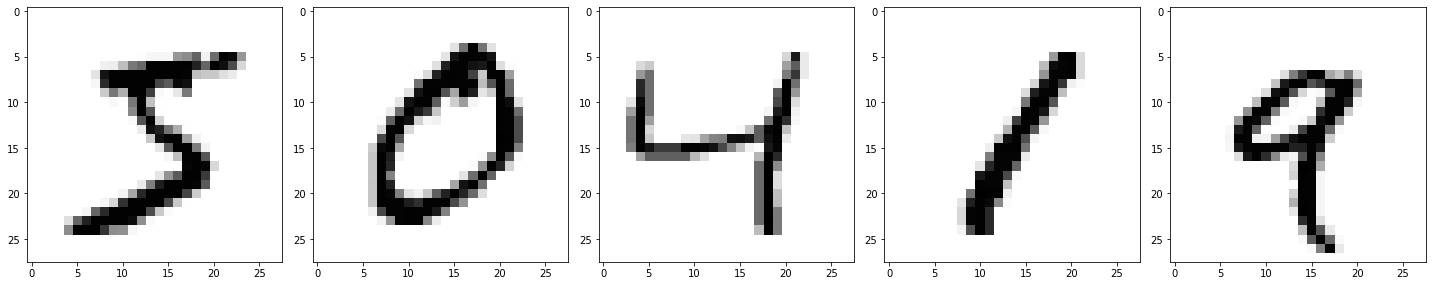

In [0]:
fig, axes = plt.subplots(1, 5, figsize=(20,15))
axes = axes.flatten()
for img, ax in zip(X_train[:5].reshape((-1,28,28)), axes):
    ax.imshow(img, cmap="Greys")
plt.tight_layout()
plt.show()

In [0]:
def train_test_split(X,y,ratio=0.1):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    n = int(n_samples*ratio)
    test_indices = indices[:n]
    train_indices = indices[n:]

    return X[train_indices], y[train_indices], X[test_indices], y[test_indices]

X_train, y_train, X_val, y_val = train_test_split(X_train, y_train)

In [0]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [0]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1

In [113]:
net = Sequential()
net.add(Linear(784, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Linear(128, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

criterion = NLLCriterion()

print(net)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 10
LogSoftMax



In [0]:
# Optimizer params
optimizer_config = {'learning_rate' : 0.5, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 6
batch_size = 512

In [0]:
n_iters = X_train.shape[0] // batch_size
if X_train.shape[0] % batch_size > 0:
    n_iters += 1

n_val_iters = X_val.shape[0] // batch_size
if X_val.shape[0] % batch_size > 0:
    n_val_iters += 1

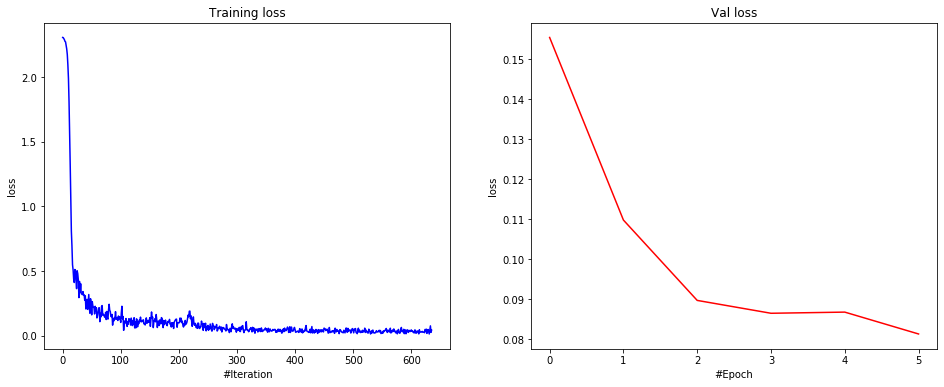

[5] train loss: 0.033980758290309	val loss: 0.08135255659633887


In [116]:
from IPython import display

history = []
val_losses = []
for i in range(n_epoch):
    net.train()
    
    # LR schedule
    if i>=2:
        optimizer_config['learning_rate'] = 0.05

    train_loss = 0
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        y_batch = y_batch.reshape(-1)
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        train_loss += loss
        history.append(loss)
    train_loss /= n_iters


    net.evaluate()
    val_loss = 0
    for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
        y_batch = y_batch.reshape(-1)
        
        # Forward
        predictions = net.forward(x_batch)
        val_loss += criterion.forward(predictions, y_batch)  

    val_loss /= n_val_iters
    val_losses.append(val_loss)
        

    # Visualize    
    display.clear_output(wait=True)
    #plt.figure(figsize=(8, 6))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
    ax1.set_title("Training loss")
    ax1.set(xlabel="#Iteration", ylabel="loss")
    ax1.plot(history, 'b')

    ax2.set_title("Val loss")
    ax2.set(xlabel="#Epoch", ylabel="loss")
    ax2.plot(val_losses, 'r')

    plt.show()
    print('[{}] train loss: {}\tval loss: {}'.format(i, train_loss, val_loss))

In [0]:
y_pred = np.argmax(net.forward(X_test), axis=1)

In [118]:
def accuracy(y_pred, y_true):
    return sum(y_pred == y_true) / len(y_true)

acc = accuracy(y_pred, y_test.reshape(-1))
print("Accuracy on test: {}%".format(acc*100))

Accuracy on test: 98.02%


Misclassified images


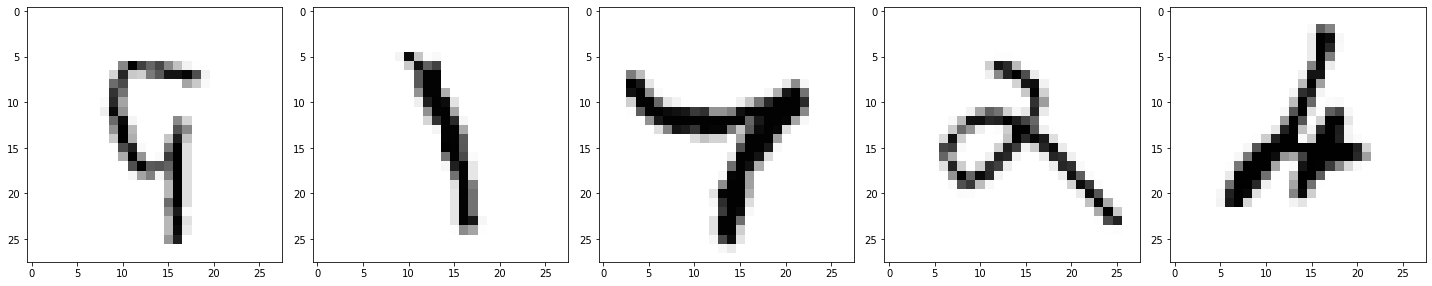

True label:	 9 1 7 2 4
Classified as:	 5 9 4 8 2


In [136]:
print("Misclassified images")
misclass = (X_test[y_pred != y_test.reshape(-1)] + 1)/2*255
misclass = misclass.astype(np.uint8)

fig, axes = plt.subplots(1, 5, figsize=(20,15))
axes = axes.flatten()
for img, ax in zip(misclass[:5].reshape((-1,28,28)), axes):
    ax.imshow(img, cmap="Greys")
plt.tight_layout()
plt.show()

print("True label:\t",*y_test[y_pred != y_test.reshape(-1)].reshape(-1)[:5])
print("Classified as:\t",*y_pred[y_pred != y_test.reshape(-1)][:5])